In [1]:
import os
import time
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx
import threading
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import itertools as it

/home/ucfnhbx/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Mainland Europe

In [2]:
# all of europe
# https://hub.arcgis.com/datasets/esri::world-continents/explore?filters=eyJDT05USU5FTlQiOlsiRXVyb3BlIl19&location=-0.592498%2C179.999994%2C2.03
europe = gpd.read_file('Data/Europe.geojson')
#europe.total_bounds
#europe.crs

In [9]:
multipolygon = europe.geometry[0]
polygons = list(europe.geometry[0])

sizes = []
for polygon in multipolygon:
    sizes.append(polygon.area)
    
landsize = pd.DataFrame(polygons)
landsize['size'] = sizes
landsize = landsize.sort_values('size', ascending=False)
landsize = gpd.GeoDataFrame(landsize, geometry=0, crs='EPSG:4326')
mainlands = landsize.iloc[[0,1,5],:]
mainland = landsize.iloc[[0],:] #max(multipolygon, key=lambda a: a.area)
isles = landsize.iloc[[1,5],:]

<ipython-input-9-71785a7b48d2>:2: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  polygons = list(europe.geometry[0])
<ipython-input-9-71785a7b48d2>:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygons = list(europe.geometry[0])
<ipython-input-9-71785a7b48d2>:5: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in multipolygon:


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

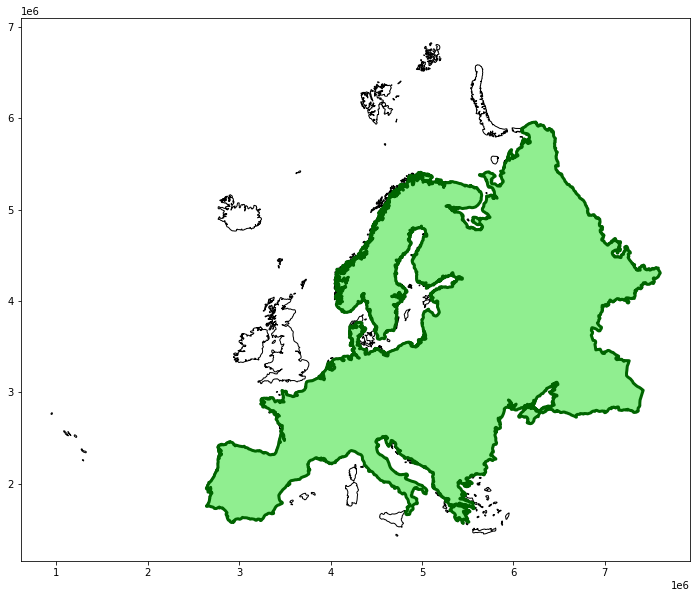

In [68]:
# plot mainland Europe polygon

#mainland.to_crs("EPSG:3035").centroid
fig, ax = plt.subplots(figsize=(12, 10))
#mainland.to_crs("EPSG:3035").envelope.plot(ax=ax, color='gold')
europe.to_crs("EPSG:3035").plot(ax=ax, color = 'white', edgecolor='black')
mainland.to_crs("EPSG:3035").plot(ax=ax, color = 'lightgreen', edgecolor='darkgreen', linewidth=3)
#grid[0:400].to_crs("EPSG:3035").plot(ax=ax, color='red')

# save plot
plt.savefig("Figs/plot_mainland.png")

In [8]:
#mainlands.plot();
#mainlands.to_file('Data/mainlands.geojson', driver='GeoJSON')
()
mainland.plot();
mainland.to_file('Data/mainland.geojson', driver='GeoJSON')
#isles.plot();
#isles.to_file('Data/isles.geojson', driver='GeoJSON')

TypeError: 'CRS' object is not callable

## EEA grid

In [17]:
# https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2
EEAgrid = gpd.read_file('Data/Europe.zip')
#EEAgrid.to_file('Data/eea.geojson', driver='GeoJSON')
# origin is at bottom left

In [43]:
# dimensions of grid
print(EEAgrid.crs)
print(EEAgrid.shape)

epsg:3035
(5712, 4)


In [19]:
# examine grids ordering: grids in df start from top left
EEAgrid[EEAgrid.EofOrigin == EEAgrid.EofOrigin.max()] # E83 grids across
EEAgrid[EEAgrid.NofOrigin == EEAgrid.NofOrigin.max()] # N74 grids down
EEAgrid.head()

#vert = EEAgrid.dissolve(by=['EofOrigin'])
#horiz = EEAgrid.dissolve(by=['NofOrigin'])
#horiz.iloc[[-1],:].plot()

,CellCode,EofOrigin,NofOrigin,geometry
0,100kmE0N7,0,700000,"POLYGON ((0.000 700000.000, 0.000 800000.000, ..."
1,100kmE1N7,100000,700000,"POLYGON ((100000.000 700000.000, 100000.000 80..."
2,100kmE2N7,200000,700000,"POLYGON ((200000.000 700000.000, 200000.000 80..."
3,100kmE3N7,300000,700000,"POLYGON ((300000.000 700000.000, 300000.000 80..."
4,100kmE4N7,400000,700000,"POLYGON ((400000.000 700000.000, 400000.000 80..."


In [20]:
# clip grid to mainland Europe in epsg 3035 for accuracy, then save as epsg 4326 for OSMnx input
grid_europ = gpd.clip(gdf=EEAgrid, mask=mainland.to_crs("EPSG:3035"), keep_geom_type=False).to_crs("EPSG:4326")

In [24]:
#examine one grid 
#multipolygons grid_europ.loc[[1887]].plot()

#examine one row
#grid_europ.iloc[[0],:]

#examine data
#grid_europ.head()

,CellCode,EofOrigin,NofOrigin,geometry
789,100kmE33N16,3300000,1600000,"POLYGON ((-1.53670 37.68342, -0.82776 37.76725..."


In [ ]:
#save clipped grid
#grid_europ.to_file('Data/grid.geojson', driver='GeoJSON')
#grid_europ.crs

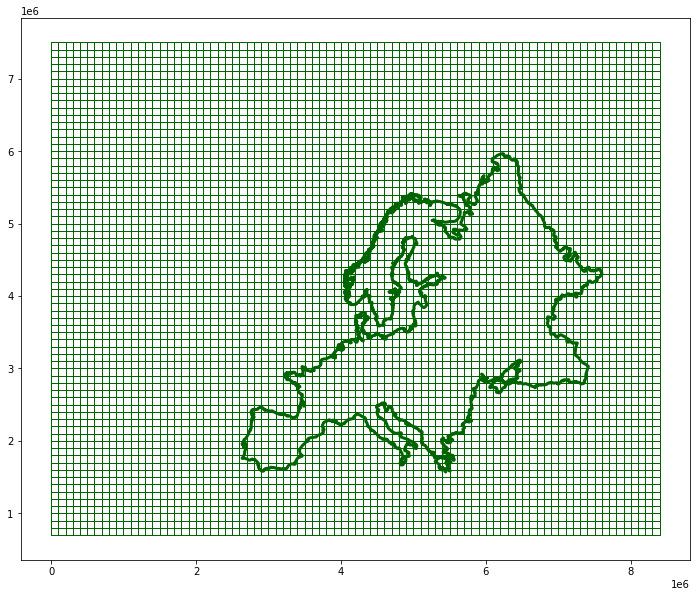

In [69]:
#plot clipped grid
fig, ax = plt.subplots(figsize=(12, 10))
EEAgrid.plot(ax=ax, edgecolor='darkgreen', facecolor="none" );
#europe.to_crs("EPSG:3035").plot(ax=ax, edgecolor='black', facecolor="none");
mainland.to_crs("EPSG:3035").plot(ax=ax, facecolor="none", edgecolor='darkgreen', linewidth=3)
plt.savefig("Figs/plot_EEA.png")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
mainland.plot(ax=ax, facecolor="none", edgecolor='darkgreen', linewidth=3)
grid_europ.plot(ax=ax, edgecolor='green', facecolor="none");
#include in plot one grid of a different color
#grid_europ.iloc[[4]].plot(ax=ax, color='red', edgecolor='blue');
plt.savefig("Figs/plot_grids.png")